### Aim
AFL is a uniquely Australian sport that forms a significant part of the Victorian identity. Founded in 1885, the Richmond Football Club is one of the longest running football clubs in Australia. Entering the Victorian Football League in 1908, the team has had a total of 1193 players play for the club to date. In this analysis, I will be using data retrieved from [afltables.com](https://afltables.com/afl/stats/teams/richmond.html) to assess the performance of past and present players in the Richmond Football Club to ultimately identify our greatest player of all time.


### Data Exploration and Preparation
#### Load libraries

In [63]:
#load libraries
library(tidyverse)
library(naniar)
library(shiny)
library(plotly)

#### Read in data

In [64]:
# Player performance data from 1965 to 2024
player_stats <-read.csv("Player Stats 1965-2024.csv")
head(player_stats)

,Player,GM,KI,MK,HB,DI,GL,BH,HO,TK,⋯,FF,FA,BR,CP,UP,CM,MI,X1.,BO,GA
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,"Bartlett, Kevin",403,8293,1086,858,9151,778,781,27,NA,⋯,931,856,160,NA,NA,NA,NA,NA,NA,NA
2,"Riewoldt, Jack",347,3085,1833,1023,4108,787,480,106,741,⋯,321,335,62,2004,2089,545,1038,582,29,249
3,"Cotchin, Trent",306,4019,993,2877,6896,141,123,48,1132,⋯,463,306,148,3262,3575,74,104,402,112,163
4,"Edwards, Shane",303,2451,789,2693,5144,189,154,15,838,⋯,195,250,17,2306,2805,78,144,402,133,211
5,"Martin, Dustin",301,4556,1167,2748,7304,338,230,18,835,⋯,245,401,212,2935,4333,172,219,335,251,221
6,"Bourke, Francis",300,4163,1054,1288,5451,71,57,34,NA,⋯,715,696,139,NA,NA,NA,NA,NA,NA,NA


#### Data Wrangling

In [65]:
# Initial exploration
# View data dimensions
cat("Number of rows:", nrow(player_stats), "\n")
cat("Number of columns:", ncol(player_stats), "\n")

#Is there missing data?
cat("\n", "Amount of missing data per column:", "\n")
print(colSums(is.na(player_stats)))

Number of rows: 550 
Number of columns: 24 

 Amount of missing data per column: 
Player     GM     KI     MK     HB     DI     GL     BH     HO     TK     RB 
     0      0      3     19     10      3    105     98    246    223    339 
    IF     CL     CG     FF     FA     BR     CP     UP     CM     MI    X1. 
   324    337    323     27     22    308    329    329    350    358    336 
    BO     GA 
   385    380 


Our Player Stats dataset contains data for 550 players across 24 attributes. Some missing data is to be expected (e.g. a team's full back would rarely kick a goal), however certain columns have a lot more than is reasonable. When reviewing the data, we find that some attributes only started being recorded during the 1998 and 1999 AFL seasons. Therefore, we will need to split our data into 'core' attributes, recorded since 1965, and 'modern' attributes, recorded since 1998/1999.

Additionally, some statistics are redundant and will be removed from our dataset. For example, while we care about the number of marks a player has taken, whether they were contested or uncontested is not. Similarly, the number of Brownlow votes a player accrues reflects the umpires' opinions which may not reflect pure performance.

Before starting our analysis, we will also address any missing data by replacing null values with zeros. As we are searching for the best Richmond player of all time, players with less than 100 games will also be dropped. This hurdle has been set to align with the father-son rule, an established indicator of a player's high contribution to their club.

In [66]:
# data cleaning

# drop columns
player_stats <- subset(player_stats, select = -c(HO, BR, CP, UP, CM, MI, BO, GA))
# rename X1. column
names(player_stats)[which(names(player_stats) == "X1.")] <- "1P"
# replace NA with 0
player_stats[is.na(player_stats)] <- 0
# drop players with less than 100 games
player_stats <- filter(player_stats, player_stats$GM >=100)

I will create a new column 'ACC' that uses the goals and behinds data to calculate each player's accuracy.

In [67]:
# create accuracy column
player_stats <- mutate(player_stats, ACC = GL / (GL + BH))
# move accuracy column next to GL column
player_stats <- relocate(player_stats, ACC, .after=GL)
# drop behinds column
player_stats <- select(player_stats, "Player", "GM", "KI", "MK", "HB", "DI", "GL", "ACC", "TK", "RB", "IF", "CL", "CG", "FF", "FA", "1P")

While there is some subjectivity, free kicks are usually awarded to players for being first to the ball or for strong tackling and given for undisciplined play. In this analysis, a free kick differential and ratio will both be considered.

In [68]:
# create differential column
player_stats <- mutate(player_stats, FD = FF - FA)
player_stats <- relocate(player_stats, FD, .after=FA)
# create ratio column
player_stats <- mutate(player_stats, FR = FF / FA)
player_stats <- relocate(player_stats, FR, .after=FD)
# drop frees for and against columns
player_stats <- select(player_stats, "Player", "GM", "KI", "MK", "HB", "DI", "GL", "ACC", "TK", "RB", "IF", "CL", "CG", "FD", "FR", "1P")

The Disposals attribute is a summation of the Kicks and Handballs columns and as such will not be used on its own. I will instead combine this metric with the Clangers attribute to assess each player's disposal efficiency.

In [69]:
# create disposal efficiency column
player_stats <- mutate(player_stats, DE = (DI - CG)/DI*100)
player_stats <- relocate(player_stats, DE, .after=DI)
player_stats$DE[player_stats$CG == 0] <- 0
# drop disposals and clangers columns
player_stats <- select(player_stats, "Player", "GM", "KI", "MK", "HB", "DE", "GL", "ACC", "TK", "RB", "IF", "CL", "FD", "FR", "1P")

When evaluating player performances, the use of total values alone will skew our findings in favour of those with a higher number of games played. While this is warranted with more games and higher stats being a strong indicator of a better player, I want to balance this by incorporating per game averages into the analysis. This additional dataset will not include the GM, DE, ACC and FD columns.

In [70]:
# create per game dataframe
player_stats_per_game <- player_stats
player_stats_per_game[,3:15] <- player_stats_per_game[, 3:15] / player_stats_per_game$GM
player_stats_per_game$FR <- player_stats_per_game$FR * player_stats_per_game$GM
#drop GM, DE, ACC, FD columns
player_stats_per_game <- select(player_stats_per_game, "Player", "KI", "MK", "HB", "GL", "TK", "RB", "IF", "CL", "FR", "1P")
#drop FR column from totals
player_stats_totals <- select(player_stats, "Player", "GM", "KI", "MK", "HB", "DE", "GL", "ACC", "TK", "RB", "IF", "CL", "FD", "1P")

Now that the data has been cleaned and prepared, I can return to resolving the issue of additional statistics being included for players from the 1998 season onward. I will create two sets of tables, one featuring the core stats collected since 1965 and the other including the full range of metrics. The analysis will initially use the core statistics to compare players from across the years after which I will expand its scope to incorporate the additional performance attributes to see how they affect the rankings of the modern players.

In [71]:
# Extract core player stats into its own data set
core_ps_totals <- select(player_stats_totals, Player, GM, KI, MK, HB, GL, ACC, FD)
core_ps_per_game <- select(player_stats_per_game, Player, KI, MK, HB, GL, FR)

A data dictionary is provided below:

In [72]:
Column_Name <- c("Player", "GM", "KI", "MK", "HB", "DE", "GL", "ACC", "TK", "RB", "IF", "CL", "FD", "FR", "1P")
Description <- c("Player Name", "Games", "Kicks", "Marks", "Handballs", "Disposal Efficiency", "Goals", "Accuracy", "Tackles", "Rebound 50s", "Inside 50s", "Clearances", "Free Differential", "Free Ratio", "1 Percenters")
dict <- data.frame(Column_Name, Description)
print.data.frame(dict, row.names = FALSE, max = NULL)

 Column_Name         Description
      Player         Player Name
          GM               Games
          KI               Kicks
          MK               Marks
          HB           Handballs
          DE Disposal Efficiency
          GL               Goals
         ACC            Accuracy
          TK             Tackles
          RB         Rebound 50s
          IF          Inside 50s
          CL          Clearances
          FD   Free Differential
          FR          Free Ratio
          1P        1 Percenters


### Player Analysis

This analysis will be conducted by ranking players according to their performance in each attribute and then summing these values to calculate a final 'performance score'. As shown below with the 'Games' statistic as an example, each attribute has a positively skewed distribution.

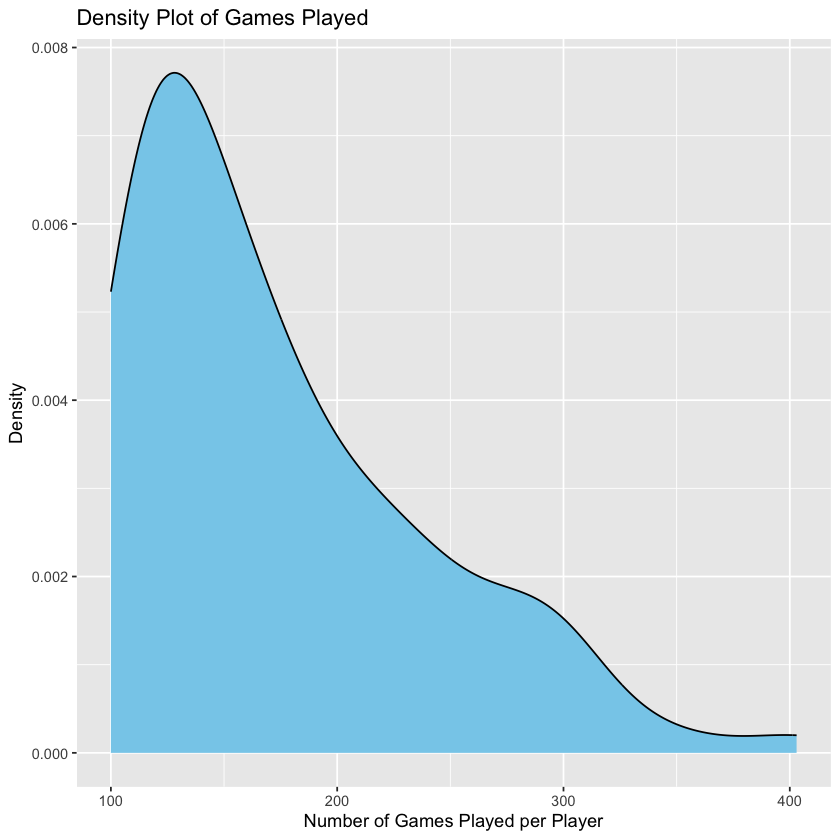

In [73]:
# Density plot
ggplot(core_ps_totals, aes(x = GM)) +
  geom_density(fill = "skyblue", color = "black") +
  labs(title = "Density Plot of Games Played", x = "Number of Games Played per Player", y = "Density")

In order to accurately compare players, the data will first be standardised by converting the raw values to z-scores and then normalised to fall across a 0-100 scale. These values will then be summed for each player to then find their final performance score. By using this method to rank and assign points to players, the difference in player performance has a greater impact as opposed to if we had done a straight point ranking of players (e.g. 10 points for best, 9 points for second best...). This will be completed for both the totals data and the per game data with these two results being combined according to their weighting, producing a final ranking of all players.

Note that in an effort to maintain balance between playing positions, the Goals and Accuracy metrics will be awarded half points. Additionally, only players who have kicked more than the median number of goals can receive points for accuracy.


#### Core Attributes

Ranking player performance based on totals.

In [74]:
# calculate z-scores for each stat
stats <- c('GM', 'KI', 'MK', 'HB', 'GL', 'ACC', 'FD')
for (stat in stats) {
  z_col <- paste0(stat, "_z")
  core_ps_totals[[z_col]] <- scale(core_ps_totals[[stat]])
}

# normalise z-scores on a 0-100 scale
for (stat in stats) {
  points_col <- paste0(stat, "_points")
  z_col <- paste0(stat, "_z")
  core_ps_totals[[points_col]] <- 50 + (core_ps_totals[[z_col]] * 10)
}

# Removing points from ACC where GL is lower than median
core_ps_totals <- mutate(core_ps_totals, ACC_points = ifelse(GL < median(GL), 0, ACC_points))

# GL and ACC columns are worth half points
core_ps_totals$GL_points <- core_ps_totals$GL_points/2
core_ps_totals$ACC_points <- core_ps_totals$ACC_points/2

# sum the points for each player in a new 'summed_points' column
points_cols <- paste0(stats, "_points")
core_ps_totals$summed_totals <- rowSums(core_ps_totals[points_cols])

Ranking player performance based on per game averages

In [75]:
# calculate z-scores for each stat
stats <- c('KI', 'MK', 'HB', 'GL', 'FR')
for (stat in stats) {
  z_col <- paste0(stat, "_z")
  core_ps_per_game[[z_col]] <- scale(core_ps_per_game[[stat]])
}

# normalise z-scores on a 0-100 scale
for (stat in stats) {
  points_col <- paste0(stat, "_points")
  z_col <- paste0(stat, "_z")
  core_ps_per_game[[points_col]] <- 50 + (core_ps_per_game[[z_col]] * 10)
} 

# sum the points for each player in a new 'summed_points' column
points_cols <- paste0(stats, "_points")
core_ps_per_game$summed_averages <- rowSums(core_ps_per_game[points_cols])

Calculate final player performance

In [76]:
# Calculate final rankings
Ranking <- inner_join(select(core_ps_totals, Player, summed_totals),
                       select(core_ps_per_game, Player, summed_averages),
                       by = "Player")
Ranking$final_ranking <- Ranking$summed_totals * 0.6 + Ranking$summed_averages * 0.4

# Order the data
Ranking <- Ranking[order(Ranking$final_ranking, decreasing = TRUE), ]

# Create a numbered list
cat("Top 10 Players based on Core Statistics:\n")
for (i in 1:10) {
  cat(i, ". ", Ranking$Player[i], "\n", sep = "")
}

Top 10 Players based on Core Statistics:
1. Bartlett, Kevin
2. Cotchin, Trent
3. Campbell, Wayne
4. Richardson, Matthew
5. Deledio, Brett
6. Riewoldt, Jack
7. Weightman, Dale
8. Bowden, Joel
9. Martin, Dustin
10. Sheedy, Kevin


Our analysis of the core statistics finds Kevin Bartlett, legend of the Richmond Football Club, having claim to the top ranking. Playing for Richmond between 1965 and 1983, he played 403 games which aids him in scoring highly across all statistics when considering the raw totals in isolation. This isn't to diminish his achievements however, with Bartlett's number of kicks being almost double the next highest total. 

Focusing on per game averages, the top two are neck and neck with Brett Deledio having a more well rounded game, and Matthew Richardson performing strongly in average goals and marks.

As the top ten list is comprised of seven players who ended their careers after 1998, I will re-run the analysis using the full data set to see how the additional records affect our findings. Obviously this will mean that players from different generations will no longer be able to be accurately compared to one another, but it will provide further insight into the performance of modern players.


#### Expanded Attributes
Using the full range of recorded metrics will provide us with a better picture of a player's performance, covering more aspects of the game. 

Ranking player performance based on totals.

In [77]:
# calculate z-scores for each stat
stats <- c("GM", "KI", "MK", "HB", "DE", "GL", "ACC", "TK", "RB", "IF", "CL", "FD", "1P")
for (stat in stats) {
  z_col <- paste0(stat, "_z")
  player_stats_totals[[z_col]] <- scale(player_stats_totals[[stat]])
}

# normalise z-scores on a 0-100 scale
for (stat in stats) {
  points_col <- paste0(stat, "_points")
  z_col <- paste0(stat, "_z")
  player_stats_totals[[points_col]] <- 50 + (player_stats_totals[[z_col]] * 10)
}

# Removing points from ACC where GL is lower than median
gl_median <- median(player_stats_totals$GL, na.rm = TRUE)
player_stats_totals$ACC_points <- ifelse(player_stats_totals$GL < gl_median, 0, player_stats_totals$ACC_points)

# GL and ACC columns are worth half points
player_stats_totals$GL_points <- player_stats_totals$GL_points/2
player_stats_totals$ACC_points <- player_stats_totals$ACC_points/2

# sum the points for each player in a new 'summed_points' column
points_cols <- paste0(stats, "_points")
player_stats_totals$summed_totals <- rowSums(player_stats_totals[points_cols])

Ranking player performance based on per game averages

In [78]:
# calculate z-scores for each stat
stats <- c("KI", "MK", "HB", "GL", "TK", "RB", "IF", "CL", "FR", "1P")
for (stat in stats) {
  z_col <- paste0(stat, "_z")
  player_stats_per_game[[z_col]] <- scale(player_stats_per_game[[stat]])
}

# normalise z-scores on a 0-100 scale
for (stat in stats) {
  points_col <- paste0(stat, "_points")
  z_col <- paste0(stat, "_z")
  player_stats_per_game[[points_col]] <- 50 + (player_stats_per_game[[z_col]] * 10)
} 

# sum the points for each player in a new 'summed_points' column
points_cols <- paste0(stats, "_points")
player_stats_per_game$summed_averages <- rowSums(player_stats_per_game[points_cols])

Calculate final player performance

In [79]:
Ranking <- inner_join(select(player_stats_totals, Player, summed_totals),
                       select(player_stats_per_game, Player, summed_averages),
                       by = "Player")
totals_weight = 0.6
averages_weight = 0.4
Ranking$final_ranking <- Ranking$summed_totals * totals_weight + Ranking$summed_averages * averages_weight

# Order the data
Ranking <- Ranking[order(Ranking$final_ranking, decreasing = TRUE), ]

# Create a numbered list
cat("Top 10 Players based on Expanded Statistics:\n")
for (i in 1:10) {
  cat(i, ". ", Ranking$Player[i], "\n", sep = "")
}

Top 10 Players based on Expanded Statistics:
1. Cotchin, Trent
2. Martin, Dustin
3. Deledio, Brett
4. Bowden, Joel
5. Campbell, Wayne
6. Riewoldt, Jack
7. Edwards, Shane
8. Houli, Bachar
9. Newman, Chris
10. Rance, Alex


Analysing the full set of data results in Trent Cotchin being named as the best modern Richmond player, with Inside 50s and Clearances providing the greatest contribution to his increased performance score from the new data. It should be recognised that between the two analyses, Wayne Campbell has dropped from third to fifth best. This is due to his career bridging the two data sets, starting in the 1991 season and ending in 2005. Therefore, the analysis of the core attributes provides a better reflection of his performance within the group.


### Visualisation

Finally these results have been visualised within an interactive Shiny app. This plot enables you to select the attributes that you feel are the most relevant to see how they affect the performance rankings. The bar chart will sort itself according to the attributes selected enabling you to view the core atributes, expanded attributes or a combination of the two.

First create a combined dataset to be used for the visualisation

In [80]:
# totals data
# drop z-score columns
merge_totals <- player_stats_totals %>% select(-matches("_z"))
# update column names for merger
new_names <- gsub("_points$", "TP", names(merge_totals))
names(merge_totals) <- new_names
# drop summed totals
merge_totals <- merge_totals[, 1:(ncol(merge_totals) - 1)]

# averages data
# drop z-score columns
merge_averages <- player_stats_per_game %>% select(-matches("_z"))
# update column names for merger
new_names <- gsub("_points$", "AvgP", names(merge_averages))
names(merge_averages) <- new_names
# drop summed averages
merge_averages <- merge_averages[, 1:(ncol(merge_averages) - 1)]

# merge datasets
combined_ps <- inner_join(merge_totals, merge_averages, by="Player")

# Rename Totals/Averages columns
#Create a copy of the original names
col_names <- names(combined_ps)
# Process columns 2 to 14
col_names[2:14] <- gsub("\\.x$", "", col_names[2:14])  # Remove .x
col_names[2:14] <- paste0(col_names[2:14], "T")        # Add T to the end
# Process columns 28 to 37
col_names[28:37] <- gsub("\\.y$", "", col_names[28:37])  # Remove .x
col_names[28:37] <- paste0(col_names[28:37], "Avg")        # Add T to the end
# Assign the new names to the data frame
names(combined_ps) <- col_names

The visualisation will display a breakdown of the points assigned to each player. This requires the points value to be aggregated at the attribute level.

In [81]:
# combine attribute point values
combined_ps$CGM <- (combined_ps$GMTP*totals_weight)
combined_ps$CKI <- (combined_ps$KITP*totals_weight)+(combined_ps$KIAvgP*averages_weight)
combined_ps$CMK <- (combined_ps$MKTP*totals_weight)+(combined_ps$MKAvgP*averages_weight)
combined_ps$CHB <- (combined_ps$HBTP*totals_weight)+(combined_ps$HBAvgP*averages_weight)
combined_ps$CDE <- (combined_ps$DETP*totals_weight)
combined_ps$CGL <- (combined_ps$GLTP*totals_weight)+(combined_ps$GLAvgP*averages_weight)
combined_ps$CACC <- (combined_ps$ACCTP*totals_weight)
combined_ps$CTK <- (combined_ps$TKTP*totals_weight)+(combined_ps$TKAvgP*averages_weight)
combined_ps$CRB <- (combined_ps$RBTP*totals_weight)+(combined_ps$RBAvgP*averages_weight)
combined_ps$CIF <- (combined_ps$IFTP*totals_weight)+(combined_ps$IFAvgP*averages_weight)
combined_ps$CCL <- (combined_ps$CLTP*totals_weight)+(combined_ps$CLAvgP*averages_weight)
combined_ps$CFD <- (combined_ps$FDTP*totals_weight)
combined_ps$CFR <- (combined_ps$FRAvgP*averages_weight)
combined_ps$C1P <- (combined_ps$`1PTP`*totals_weight)+(combined_ps$`1PAvgP`*averages_weight)

# drop original total points columns
combined_ps <- combined_ps[, -c(15:27)]
# drop original average points columns
combined_ps <- combined_ps[, -c(25:34)]
#create ranking column
combined_ps$final_rankings <- rowSums(combined_ps[25:38])

The data can now be loaded into the Shiny app. Click on the "Listening on" URL below to view and interact with the visualisation.

In [ ]:
# Load my data
playerdata <- combined_ps

# Define UI
ui <- fluidPage(

  titlePanel("Analysing the performance of the Richmond Football Club"),
  sidebarLayout(
    sidebarPanel(
      # create user input for plot1
      checkboxGroupInput("values", "Select the Metrics to Include:",
                         choices = c("Games Played" = "CGM", 
                                     "Kicks" = "CKI", 
                                     "Marks" = "CMK", 
                                     "Handballs" = "CHB", 
                                     "Disposal Efficiency" = "CDE", 
                                     "Goals" = "CGL", 
                                     "Accuracy" = "CACC", 
                                     "Tackles" = "CTK", 
                                     "Rebound 50s" = "CRB", 
                                     "Inside 50s" = "CIF", 
                                     "Clearances" = "CCL",
                                     "Free Kick Differential" = "CFD",
                                     "Free Kick Ratio" = "CFR", 
                                     "1 Percenters" = "C1P"),
                        selected = c("CGM", "CKI", "CMK", "CHB", "CDE", "CGL", 
                                      "CACC", "CTK", "CRB", "CIF", "CCL", "CFD",
                                      "CFR", "C1P")),
      
    ),
  
    mainPanel(
      h4("Who is the greatest Richmond player of all time?"),
      p("By ranking players based on their per game and total metrics, we aim to
      identify Richmond's greatest player. Focus on the metrics that matter to 
      you most by selecting your own combinations using the checkboxes on the 
      left hand side. The chart will automatically refresh to reflect your selection."),
      plotlyOutput("barChart"),
      
    ))
  )

# Define server logic
server <- function(input, output) {
  
  # specify unique colors to avoid repeats
  c1 <- "#c7dbf0"
  c2 <- "#87a353"
  c3 <- "#f5c998"
  
  # plot1
  output$barChart <- renderPlotly({
    # rank players by totals
    sorted_data <- playerdata[order(playerdata$final_rankings, decreasing=TRUE), ]
    
    # limit to top 20 players
    top_players <- head(sorted_data, 20)

    # create stacked bar chart
    performance <- plot_ly(top_players, y = ~Player, height = 700)
    
    # set each attribute within an if statement to allow reordering based on user selection
    if ("CGM" %in% input$values) {
      performance <- performance %>% add_trace(x = ~CGM, name = "Games", type = "bar", orientation = 'h',
                                               hoverinfo = "text", text = ~paste("Games: ", GMT),
                                               textposition = "none")
    }
    if ("CKI" %in% input$values) {
      performance <- performance %>% add_trace(x = ~CKI, name = "Kicks", type = "bar", orientation = 'h',
                                               hoverinfo = "text", text = ~paste("Kicks: ", KIT, "<br>", "Kicks per Game: ", KIAvg),
                                               textposition = "none")
    }
    if ("CMK" %in% input$values) {
      performance <- performance %>% add_trace(x = ~CMK, name = "Marks", type = "bar", orientation = 'h',
                                               hoverinfo = "text", text = ~paste("Marks: ", MKT, "<br>", "Marks per Game: ", MKAvg),
                                               textposition = "none")
      }
    if ("CHB" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CHB, name = "Handballs", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Handballs: ", HBT, "<br>", "Handballs per Game: ", HBAvg),
                                                 textposition = "none")
      }
      if ("CDE" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CDE, name = "Disposals Efficiency", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Disposals Efficiency: ", CDE),
                                                 textposition = "none")
      }
      if ("CGL" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CGL, name = "Goals", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Goals: ", GLT, "<br>", "Goals per Game: ", GLAvg),
                                                 textposition = "none")
      }
      if ("CACC" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CACC, name = "Accuracy", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Accuracy: ", ACCT),
                                                 textposition = "none")
      }
      if ("CTK" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CTK, name = "Tackles", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Tackles: ", TKT, "<br>", "Tackles per Game: ", TKAvg),
                                                 textposition = "none")
      }
      if ("CRB" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CRB, name = "Rebound 50s", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Rebound 50s: ", RBT, "<br>", "Rebound 50s per Game: ", RBAvg),
                                                 textposition = "none")
      }
      if ("CIF" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CIF, name = "Inside 50s", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Inside 50s: ", IFT, "<br>", "Inside 50s per Game: ", IFAvg),
                                                 textposition = "none")
      }
          if ("CCL" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CCL, name = "Clearances", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Clearances: ", CLT, "<br>", "Clearances per Game: ", CLAvg),
                                                 textposition = "none")
      }
      if ("CFR" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CFR, name = "Frees", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Ratio of free kicks given vs awarded: ", FRAvg),
                                                 textposition = "none", color=I(c1))
      }
      if ("CFD" %in% input$values) {
        performance <- performance %>% add_trace(x = ~CFD, name = "Free Differential", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("Free Kick Differential: ", FDT),
                                                 textposition = "none", color=I(c2))
      }
      if ("C1P" %in% input$values) {
        performance <- performance %>% add_trace(x = ~C1P, name = "1%", type = "bar", orientation = 'h',
                                                 hoverinfo = "text", text = ~paste("1%: ", `1PT`, "<br>", "1% per Game: ", `1PAvg`),
                                                 textposition = "none", color=I(c3))
      }
      
    performance <- performance %>% layout(barmode = 'stack', yaxis = list(title = "Players", categoryorder = "total ascending"), xaxis = list(title = "Rankings"))

  })
   
   
}

# Run the application
shinyApp(ui = ui, server = server)



Listening on http://127.0.0.1:6625

